In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/ai-incidents/incidents.csv', parse_dates=['date'], index_col=['incident_id']).drop(columns='_id')
df.head()

,date,reports,Alleged deployer of AI system,Alleged developer of AI system,Alleged harmed or nearly harmed parties,description,title
incident_id,,,,,,,
23,2017-11-08,"[242,243,244,245,246,247,248,249,250,253,254,2...","[""navya"",""keolis-north-america""]","[""navya"",""keolis-north-america""]","[""navya"",""keolis-north-america"",""bus-passengers""]",A self-driving public shuttle by Keolis North ...,Las Vegas Self-Driving Bus Involved in Accident
4,2018-03-18,"[629,630,631,632,633,634,635,636,637,638,639,6...","[""uber""]","[""uber""]","[""elaine-herzberg"",""pedestrians""]",An Uber autonomous vehicle (AV) in autonomous ...,Uber AV Killed Pedestrian in Arizona
1,2015-05-19,"[1,2,3,4,5,6,7,8,9,10,11,12,14,15]","[""youtube""]","[""youtube""]","[""children""]",YouTube’s content filtering and recommendation...,Google’s YouTube Kids App Presents Inappropria...
18,2015-04-04,"[130,131,132,133,134,135,136,137,138,1367,1368]","[""google""]","[""google""]","[""women""]",Google Image returns results that under-repres...,Gender Biases of Google Image Search
12,2016-07-21,[42],"[""microsoft-research"",""boston-university""]","[""microsoft-research"",""google"",""boston-univers...","[""women"",""minority-groups""]",Researchers from Boston University and Microso...,Common Biases of Vector Embeddings


In [2]:
from plotly.express import histogram
histogram(data_frame=df, x='date')

(-0.5, 1199.5, 1199.5, -0.5)

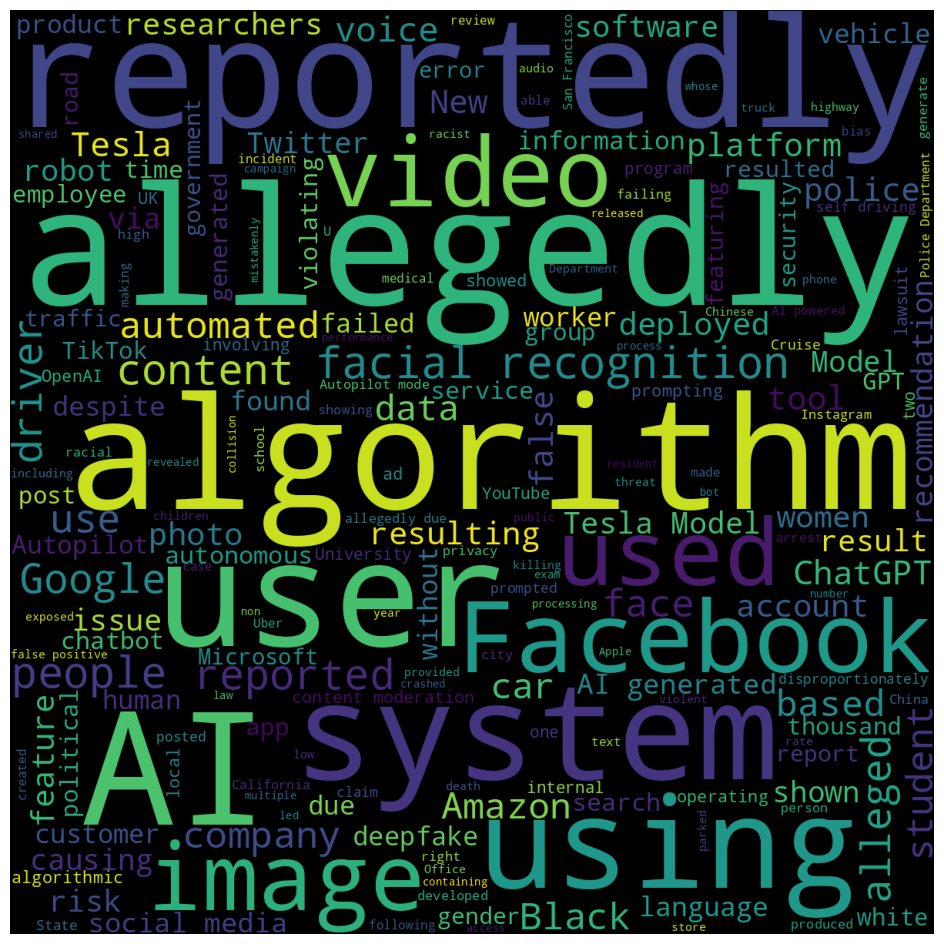

In [3]:
from matplotlib.pyplot import subplots
from matplotlib.pyplot import axis
from matplotlib.pyplot import imshow
from wordcloud import WordCloud
from wordcloud import STOPWORDS

subplots(figsize=(12, 12))
text = ' '.join(df['description'].values)
stopwords = STOPWORDS.union(set('s'))
imshow(X=WordCloud(random_state=2023, height=1200, width=1200, stopwords=stopwords ).generate(text=text), )
axis('off')